In [4]:
!pip install yellowbrick

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
import pandas_profiling as pp

%matplotlib inline

In [6]:
df = pd.read_csv('Crop_recommendation.csv')
df.head()

N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [8]:
df_copy = df.copy()

In [9]:
df_copy.drop(['label'], axis=1, inplace=True)

In [10]:
def apply_cluster(df, k = 2, eps_ = 0.5, min_samples_ = 25, kmeans = False, gaussian_mixture = False, hier = False):
    '''
    Function thats apply different number of clustring algo with defualt algo: DBscan
    '''
    if hier:
        model = AgglomerativeClustering(n_clusters = k).fit(df)
    elif kmeans:
        model = KMeans(n_clusters= k).fit(df)
    elif gaussian_mixture:
        return GaussianMixture(n_components=k).fit(df).predict(df)
    else:
        model = DBSCAN(eps = eps_, min_samples = min_samples_).fit(df)
    return model.labels_

In [11]:
def apply_no_noise(df, labels):
    '''
    returns the data with no noise
    '''
    df['out'] = labels
    return df[df['out'] != -1]
    

In [12]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Kmeans

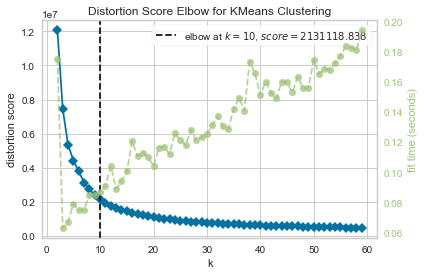

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,60))

visualizer.fit(df_copy)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [14]:
labels = apply_cluster(df_copy, k = 10, kmeans = True)

In [15]:
silhouette_score(df_copy, labels)

0.463466691649075

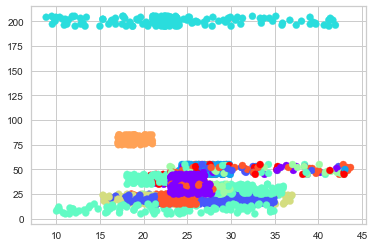

In [16]:
plt.scatter(df_copy['temperature'], df_copy['K'], c=labels, cmap='rainbow')

# Hierarchical

In [17]:
scores = []
for i in range(2, 20):
    labels = apply_cluster(df_copy, k = i, hier = True)
    scores.append(silhouette_score(df_copy, labels))
best , num_of_clusters = max(scores), scores.index(max(scores))+ 2
print(best, num_of_clusters)

0.5451227886773357 2


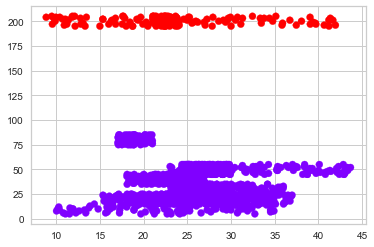

In [18]:
plt.scatter(df_copy['temperature'], df_copy['K'], c=apply_cluster(df_copy, k = 2, hier = True), cmap='rainbow')

# Gaussian Mixture

In [19]:
scores = []
for i in range(2, 20):
    labels = apply_cluster(df_copy, k = i, gaussian_mixture = True)
    scores.append(silhouette_score(df_copy, labels))
best , num_of_clusters = max(scores), scores.index(max(scores))+ 2
print(best, num_of_clusters)

0.3829176062886541 9


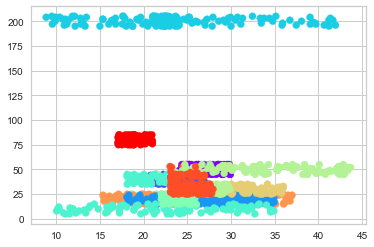

In [20]:
plt.scatter(df_copy['temperature'], df_copy['K'], c=apply_cluster(df_copy, k =11, gaussian_mixture = True), cmap='rainbow')

# DBscan

In [21]:
labels = apply_cluster(df_copy, eps_= 15, min_samples_ = 3)
silhouette_score(df_copy, labels)

0.17608134227344052

In [22]:
set(labels)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

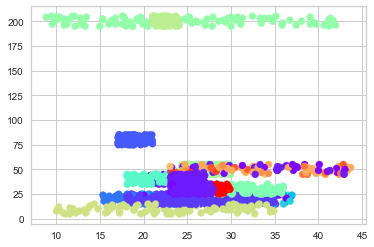

In [23]:
plt.scatter(df_copy['temperature'], df_copy['K'], c= apply_cluster(df_copy, eps_= 15, min_samples_ = 3), cmap='rainbow')

DBscan with no noise

In [24]:
labels = apply_cluster(df_copy, eps_= 15, min_samples_ = 3)
len([i for i in labels if i == -1])

49

In [25]:
data_no_noise = apply_no_noise(df_copy, labels)
labels = apply_cluster(data_no_noise, eps_= 15, min_samples_ = 3)
silhouette_score(data_no_noise, labels)

0.21142571769633495

In [26]:
set(labels)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

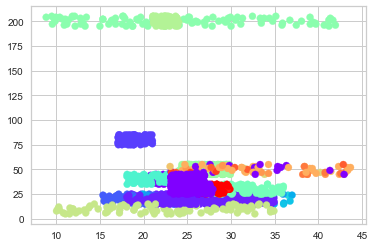

In [27]:
plt.scatter(data_no_noise['temperature'], data_no_noise['K'], c= apply_cluster(data_no_noise, eps_= 15, min_samples_ = 3), cmap='rainbow')

# Dendrogram

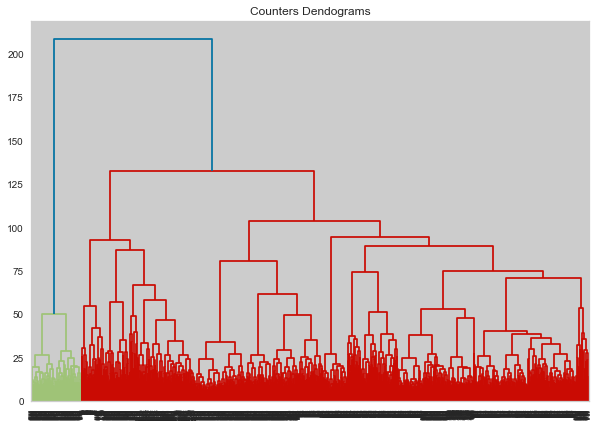

In [28]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Counters Dendograms")
dend = shc.dendrogram(shc.linkage(y = df_copy , method='average',metric='euclidean')) #fill y with your dataframe
                                                                                      #and method with linkage criteria
                                                                                      #and metric with distance function